# Compute Squared Euclidean Distance

This function have the following cost:
* adds: $D \cdot N (N-1)$
* mults: $\frac{1}{2}D \cdot N (N-1)$
* total: $\frac{3}{2}D \cdot N (N-1)$

So:
$$W = \frac{3}{2}D \cdot N (N-1)\quad flops$$

The memory traffic is computed taking into account that there is warm cache (on the previous step the whole input matrix have been accessed so it should be in cache):
$$Q = 4 \cdot N * N$$

And so the operational intensity is (for high dimensional data):
$$I \approxeq \frac{3}{8} * D = \frac{3}{8} * 28 \times 28 = 294 ~ \text{flops/byte}$$
The computation will be **compute bound**.

For lower dimensional data($D=2$):
$$I \approxeq \frac{3}{8} * D = \frac{3}{8} * 2 = \frac{6}{8} ~ \text{flops/byte}$$
The computation could be **memory bound**.


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from visualization import plot

mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

In [2]:
# Define fixed variables of the problem
D = 28*28
d = 2
D = 2
T = 1000

Lets define the flops depending on the input size.

In [3]:
def get_flops(N):
    W = 3/2 * D * N * (N - 1)
    return W

Lets import the runtime of each function.

In [4]:
data = pd.read_csv("./bench3.csv")
data

,N,base_version,blocking_4,blocking_4_unfoold_sr
0,4,9.930000e+01,144.9,124.7
1,8,2.639000e+02,302.9,261.5
2,16,1.154200e+03,3101.5,668.9
3,32,4.278600e+03,4456.5,2007.5
4,64,5.253960e+04,90003.1,7471.3
5,128,7.397260e+04,64305.9,37621.3
6,256,4.852521e+05,255762.6,125377.7
7,512,3.899125e+06,1020203.3,646939.6
8,1024,2.234273e+07,4145216.7,3913975.3
9,2048,9.147905e+07,19495861.6,15508845.0


In [5]:
# Extract the input size
N = data["N"].as_matrix()

In [6]:
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = get_flops(N)

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops / cycles
    perf.append(P)

Cache sizes and limits taking into account that the working set is:
$$W_{set} = N \cdot D + 2 N^2$$

In [7]:
cache_1 = 32 * 2**10    # 32 KB
cache_2 = 256 * 2**10   # 256 KB
cache_3 = 8 * 2**20.    # 8 MB


N_cache1 = np.sqrt(cache_1 / 4 / 2)
N_cache2 = np.sqrt(cache_2 / 4 / 2)
N_cache3 = np.sqrt(cache_3 / 4 / 2)
print(f"Cache 1 limit size: {N_cache1}")
print(f"Cache 2 limit size: {N_cache2}")
print(f"Cache 3 limit size: {N_cache3}")

Cache 1 limit size: 64.0
Cache 2 limit size: 181.01933598375618
Cache 3 limit size: 1024.0


## Benchmark 2

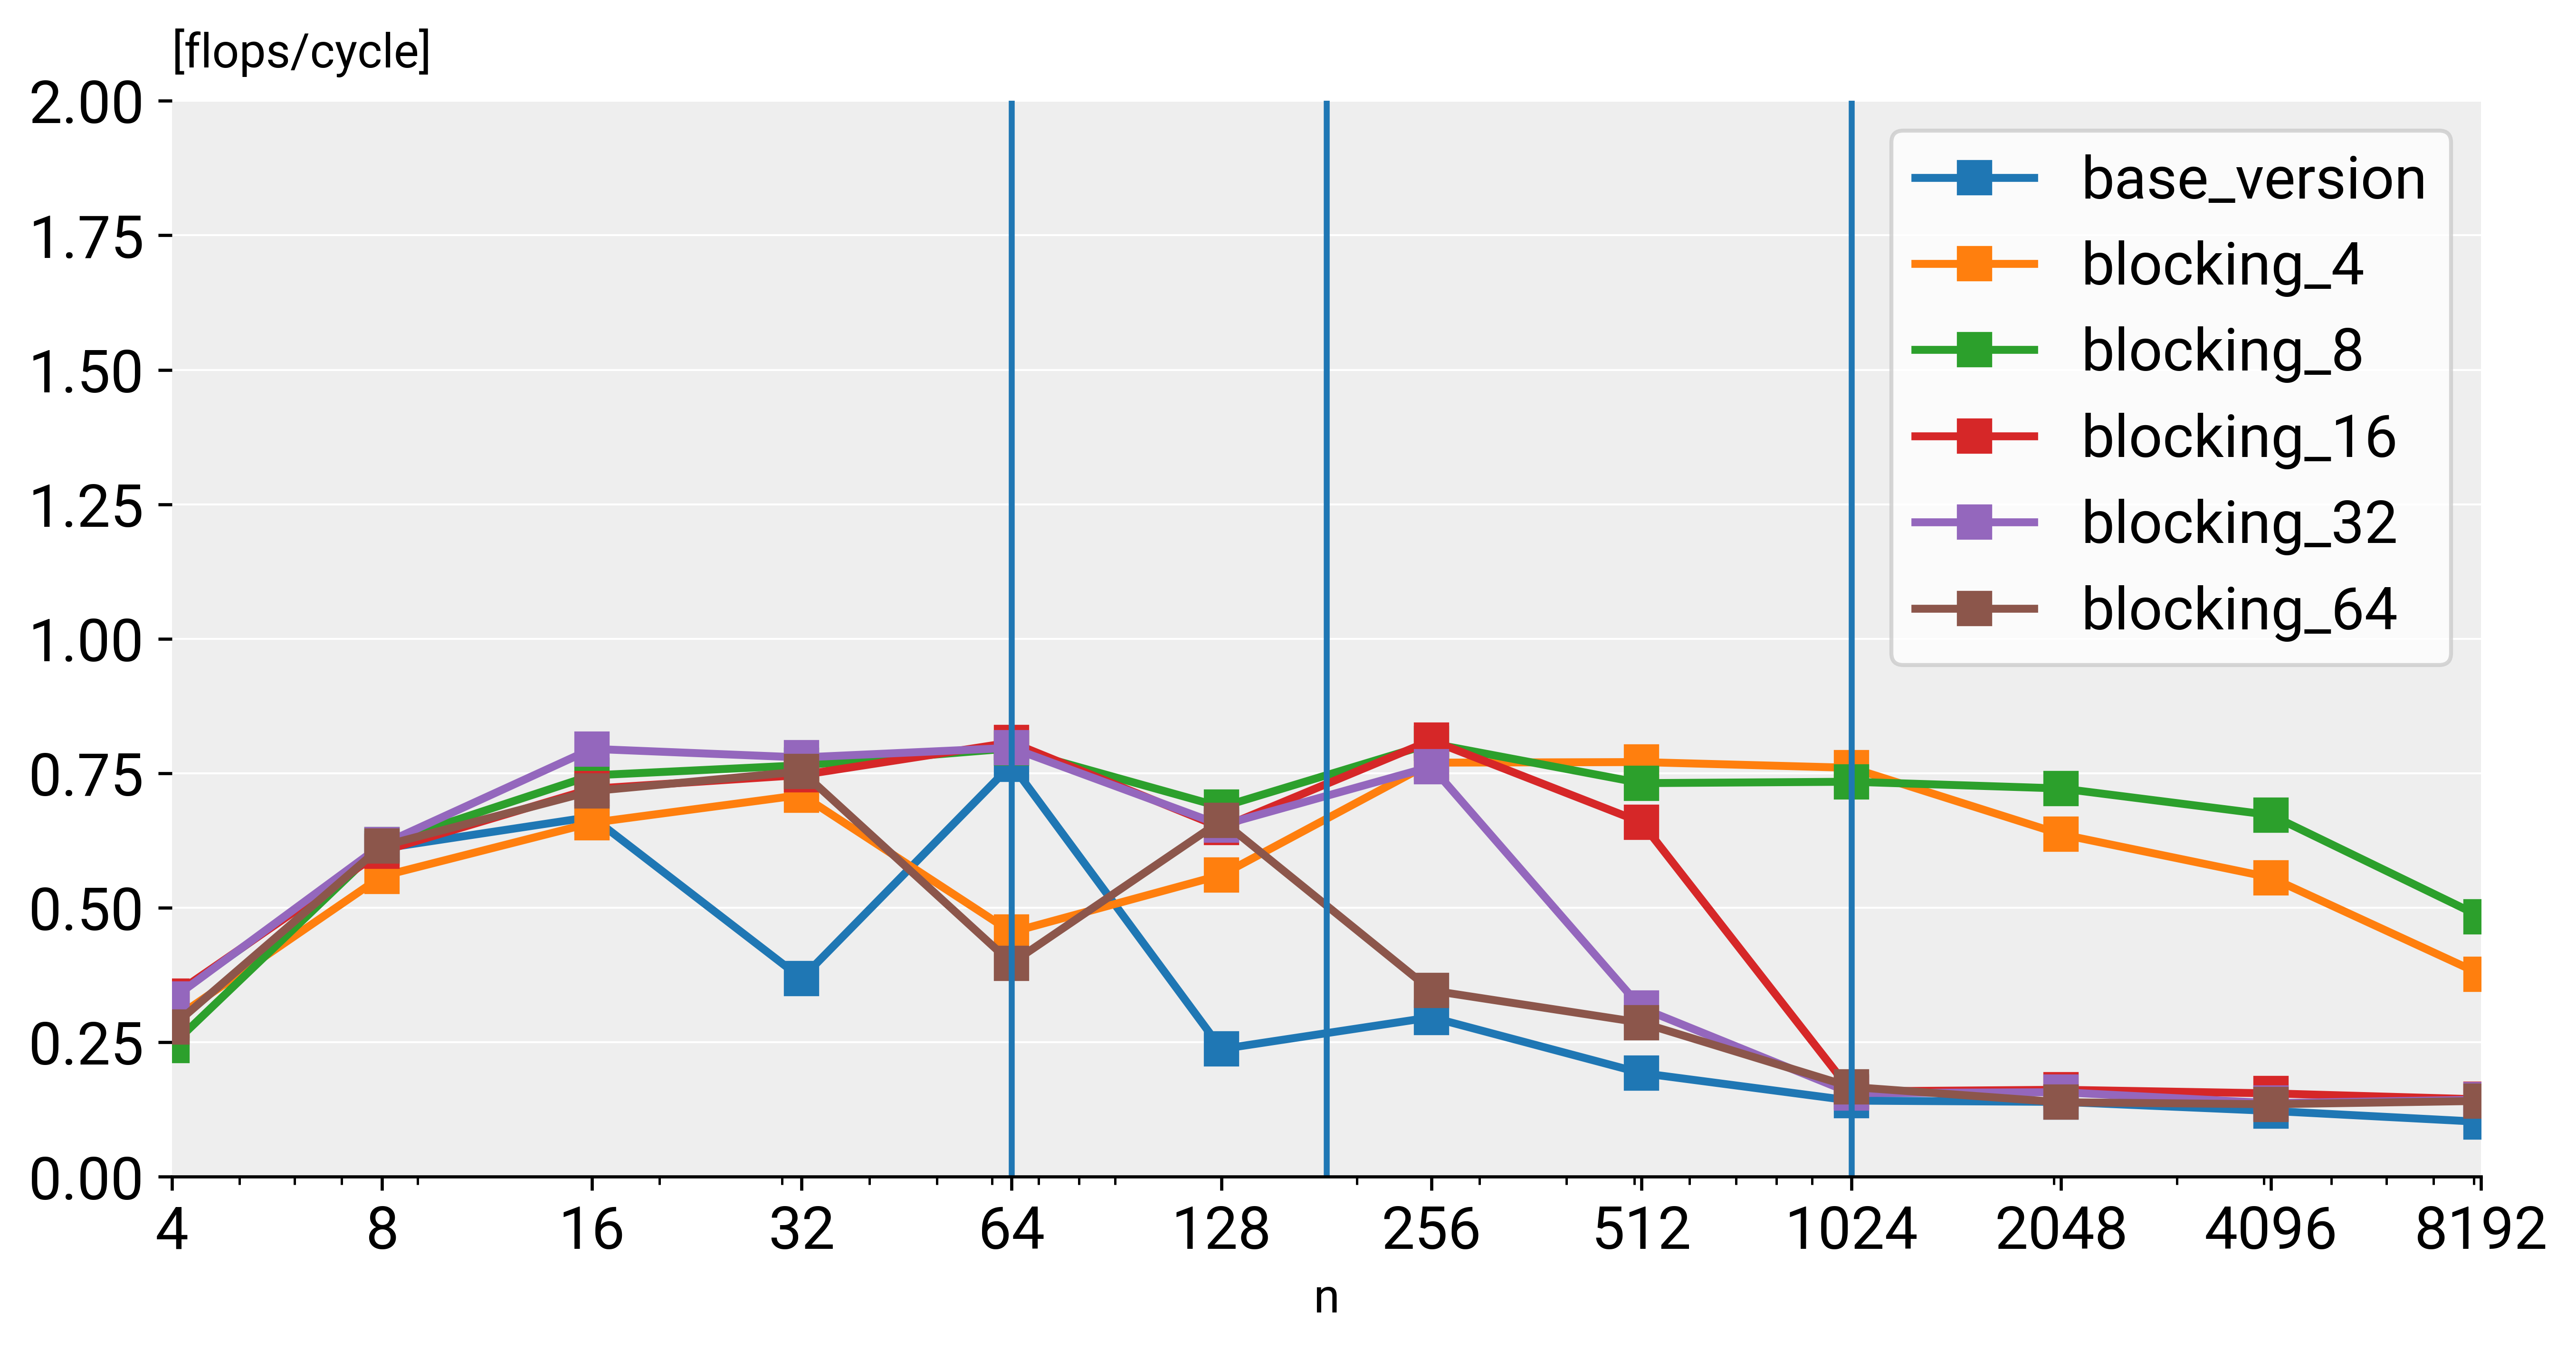

In [8]:
data = pd.read_csv("./bench2.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = get_flops(N)

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops / cycles
    perf.append(P)

ax = plot(N, perf, labels=func_names, ylim=2)
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

## Benchmark 3

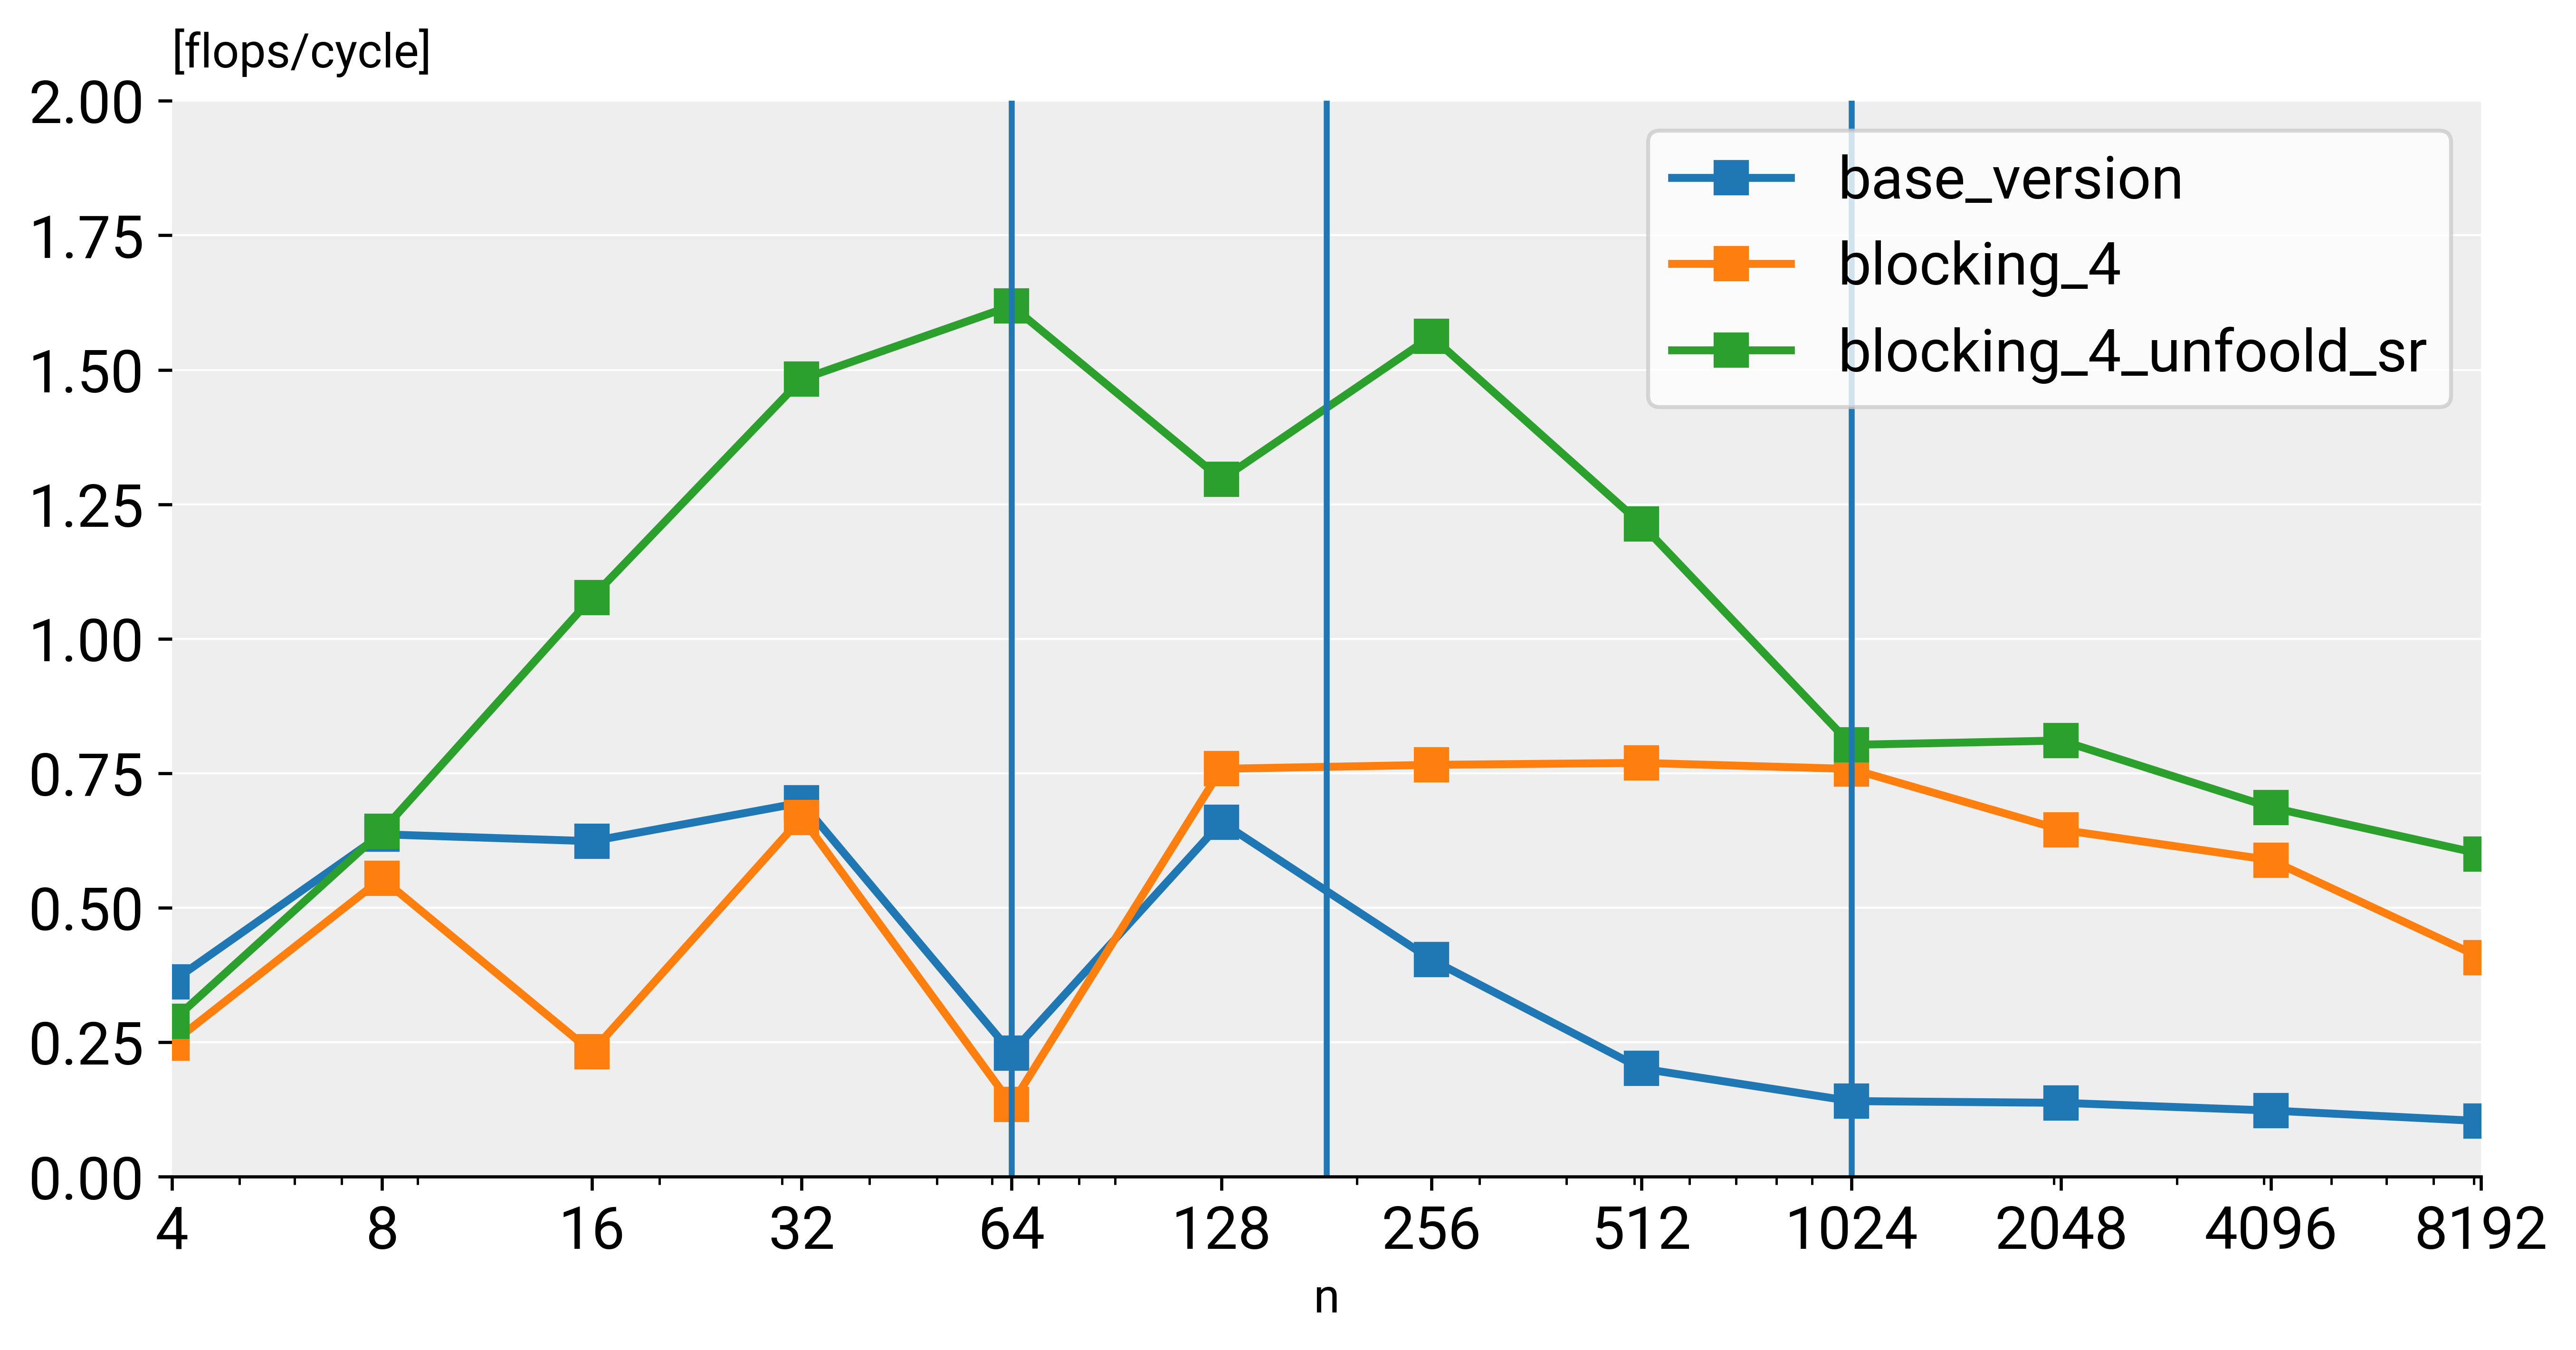

In [9]:
data = pd.read_csv("./bench3.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = get_flops(N)

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops / cycles
    perf.append(P)

ax = plot(N, perf, labels=func_names, ylim=2)
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

## Benchmark 4

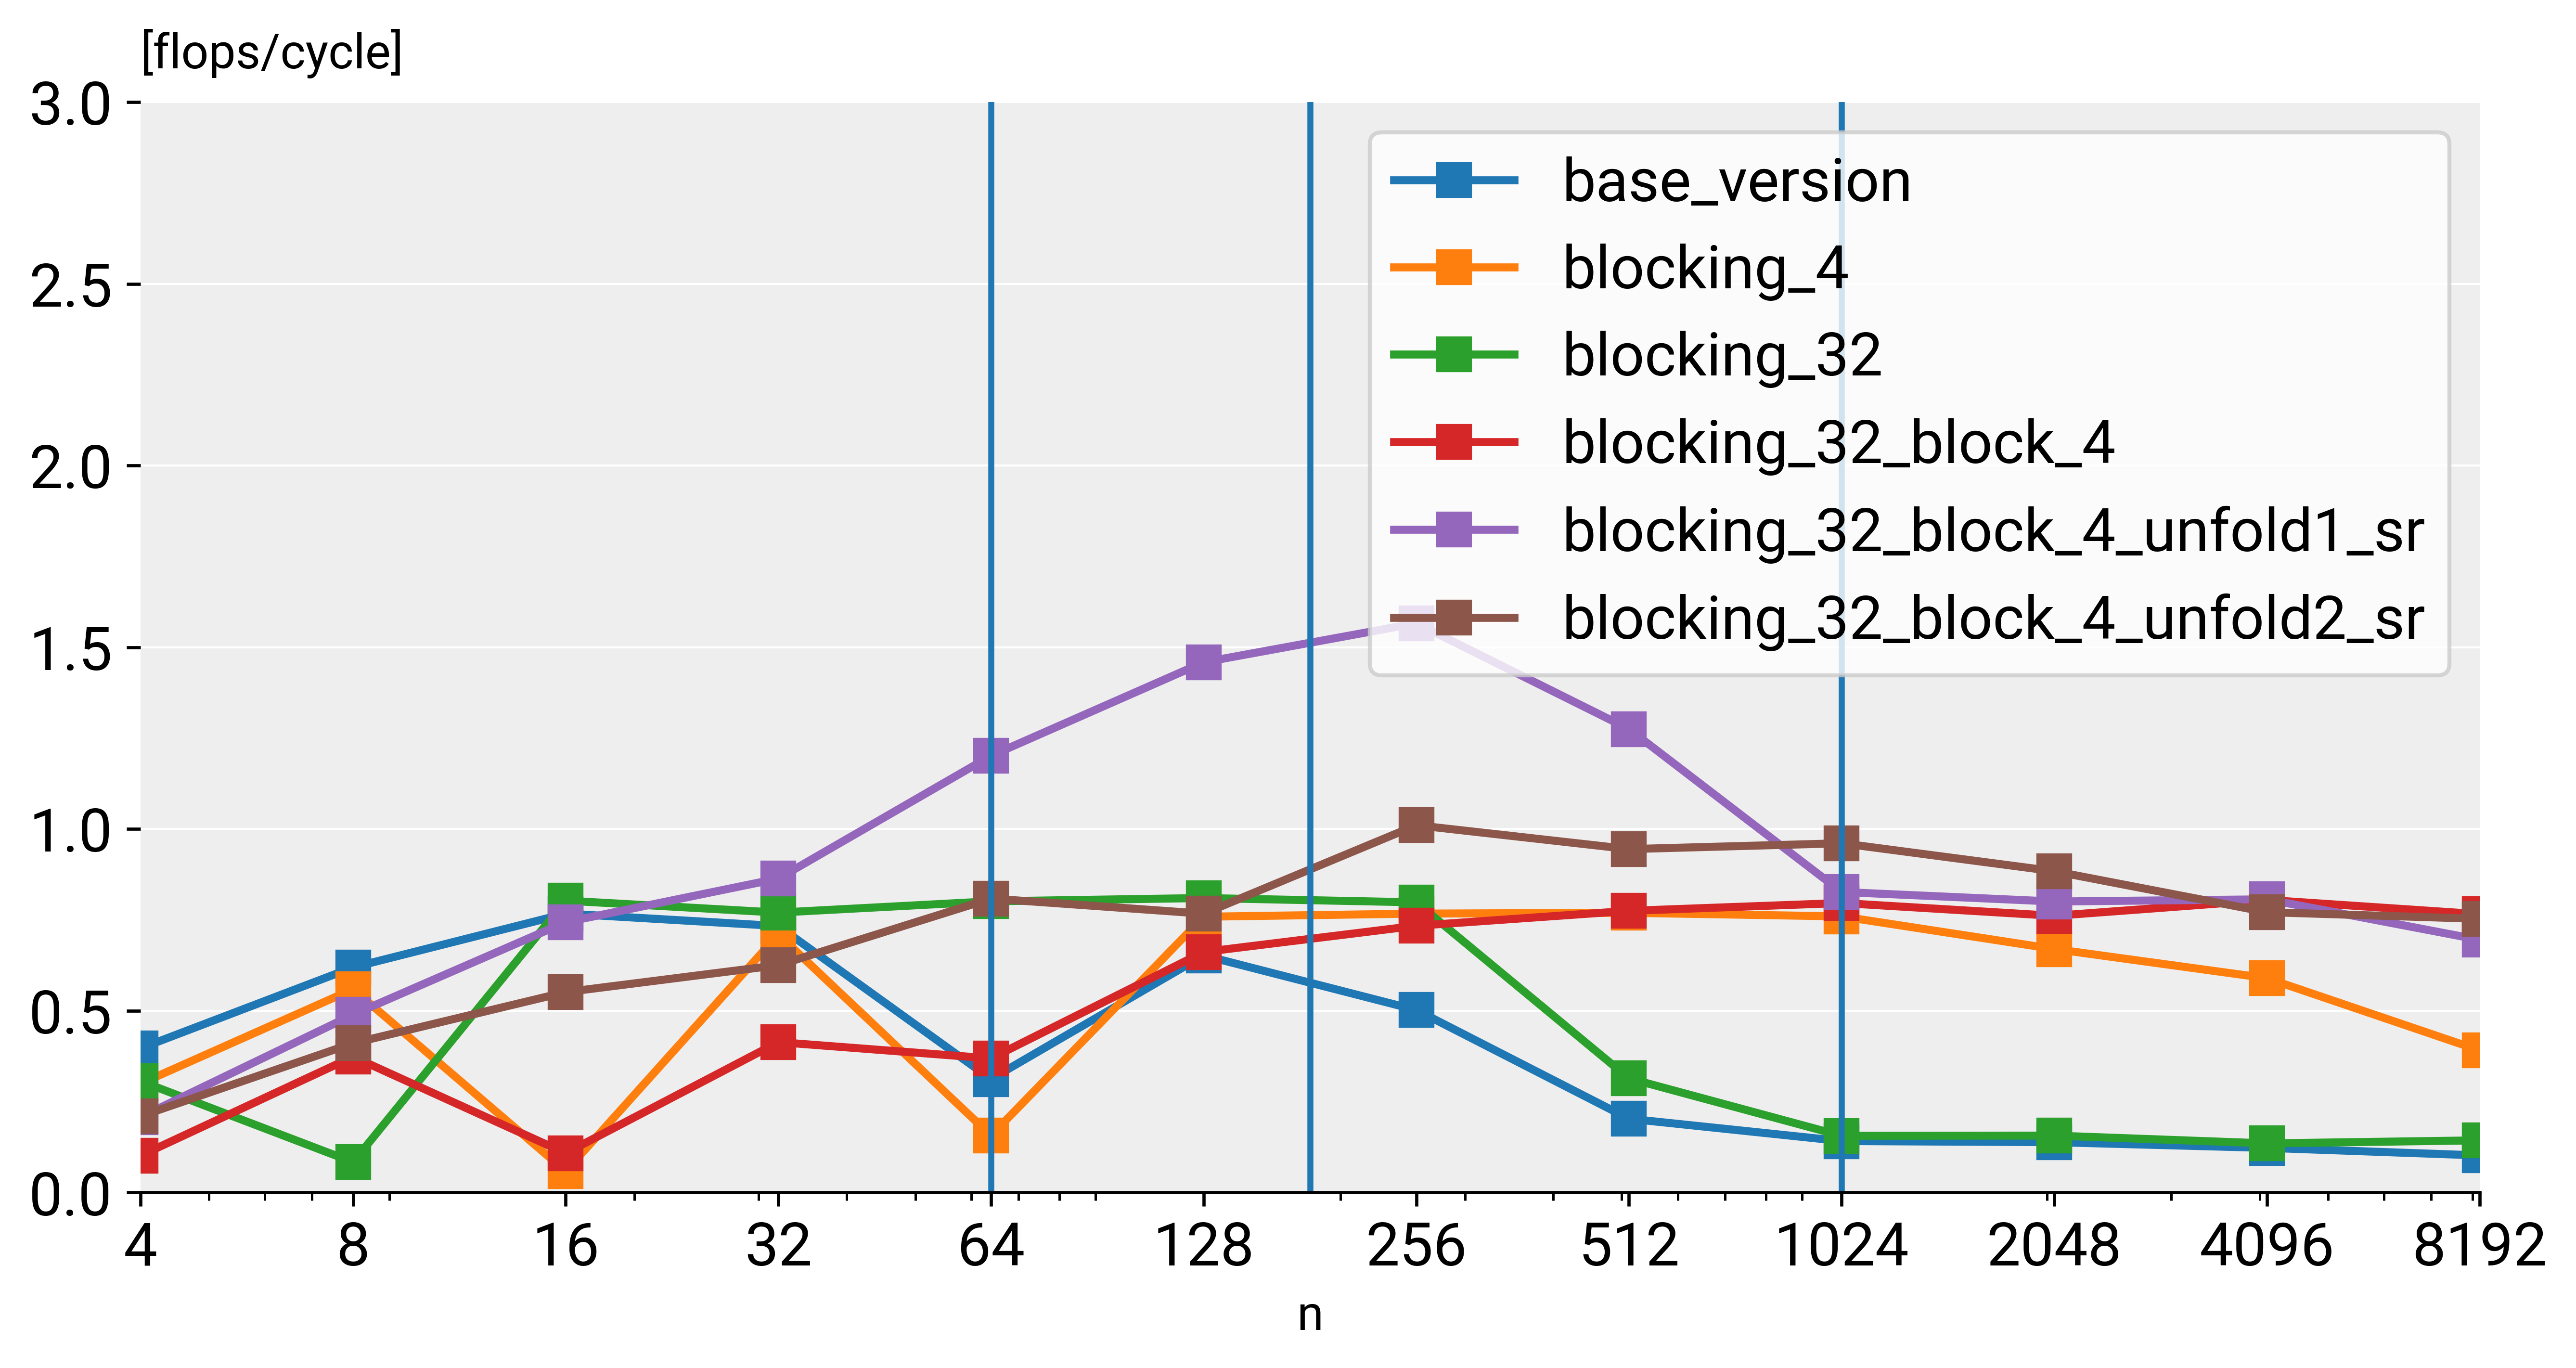

In [10]:
data = pd.read_csv("./bench4.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = get_flops(N)

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops / cycles
    perf.append(P)

ax = plot(N, perf, labels=func_names, ylim=3)
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

# Benchmark 5

Here there has been implemented the vectorized computations for the smaller block of 4 by 4.

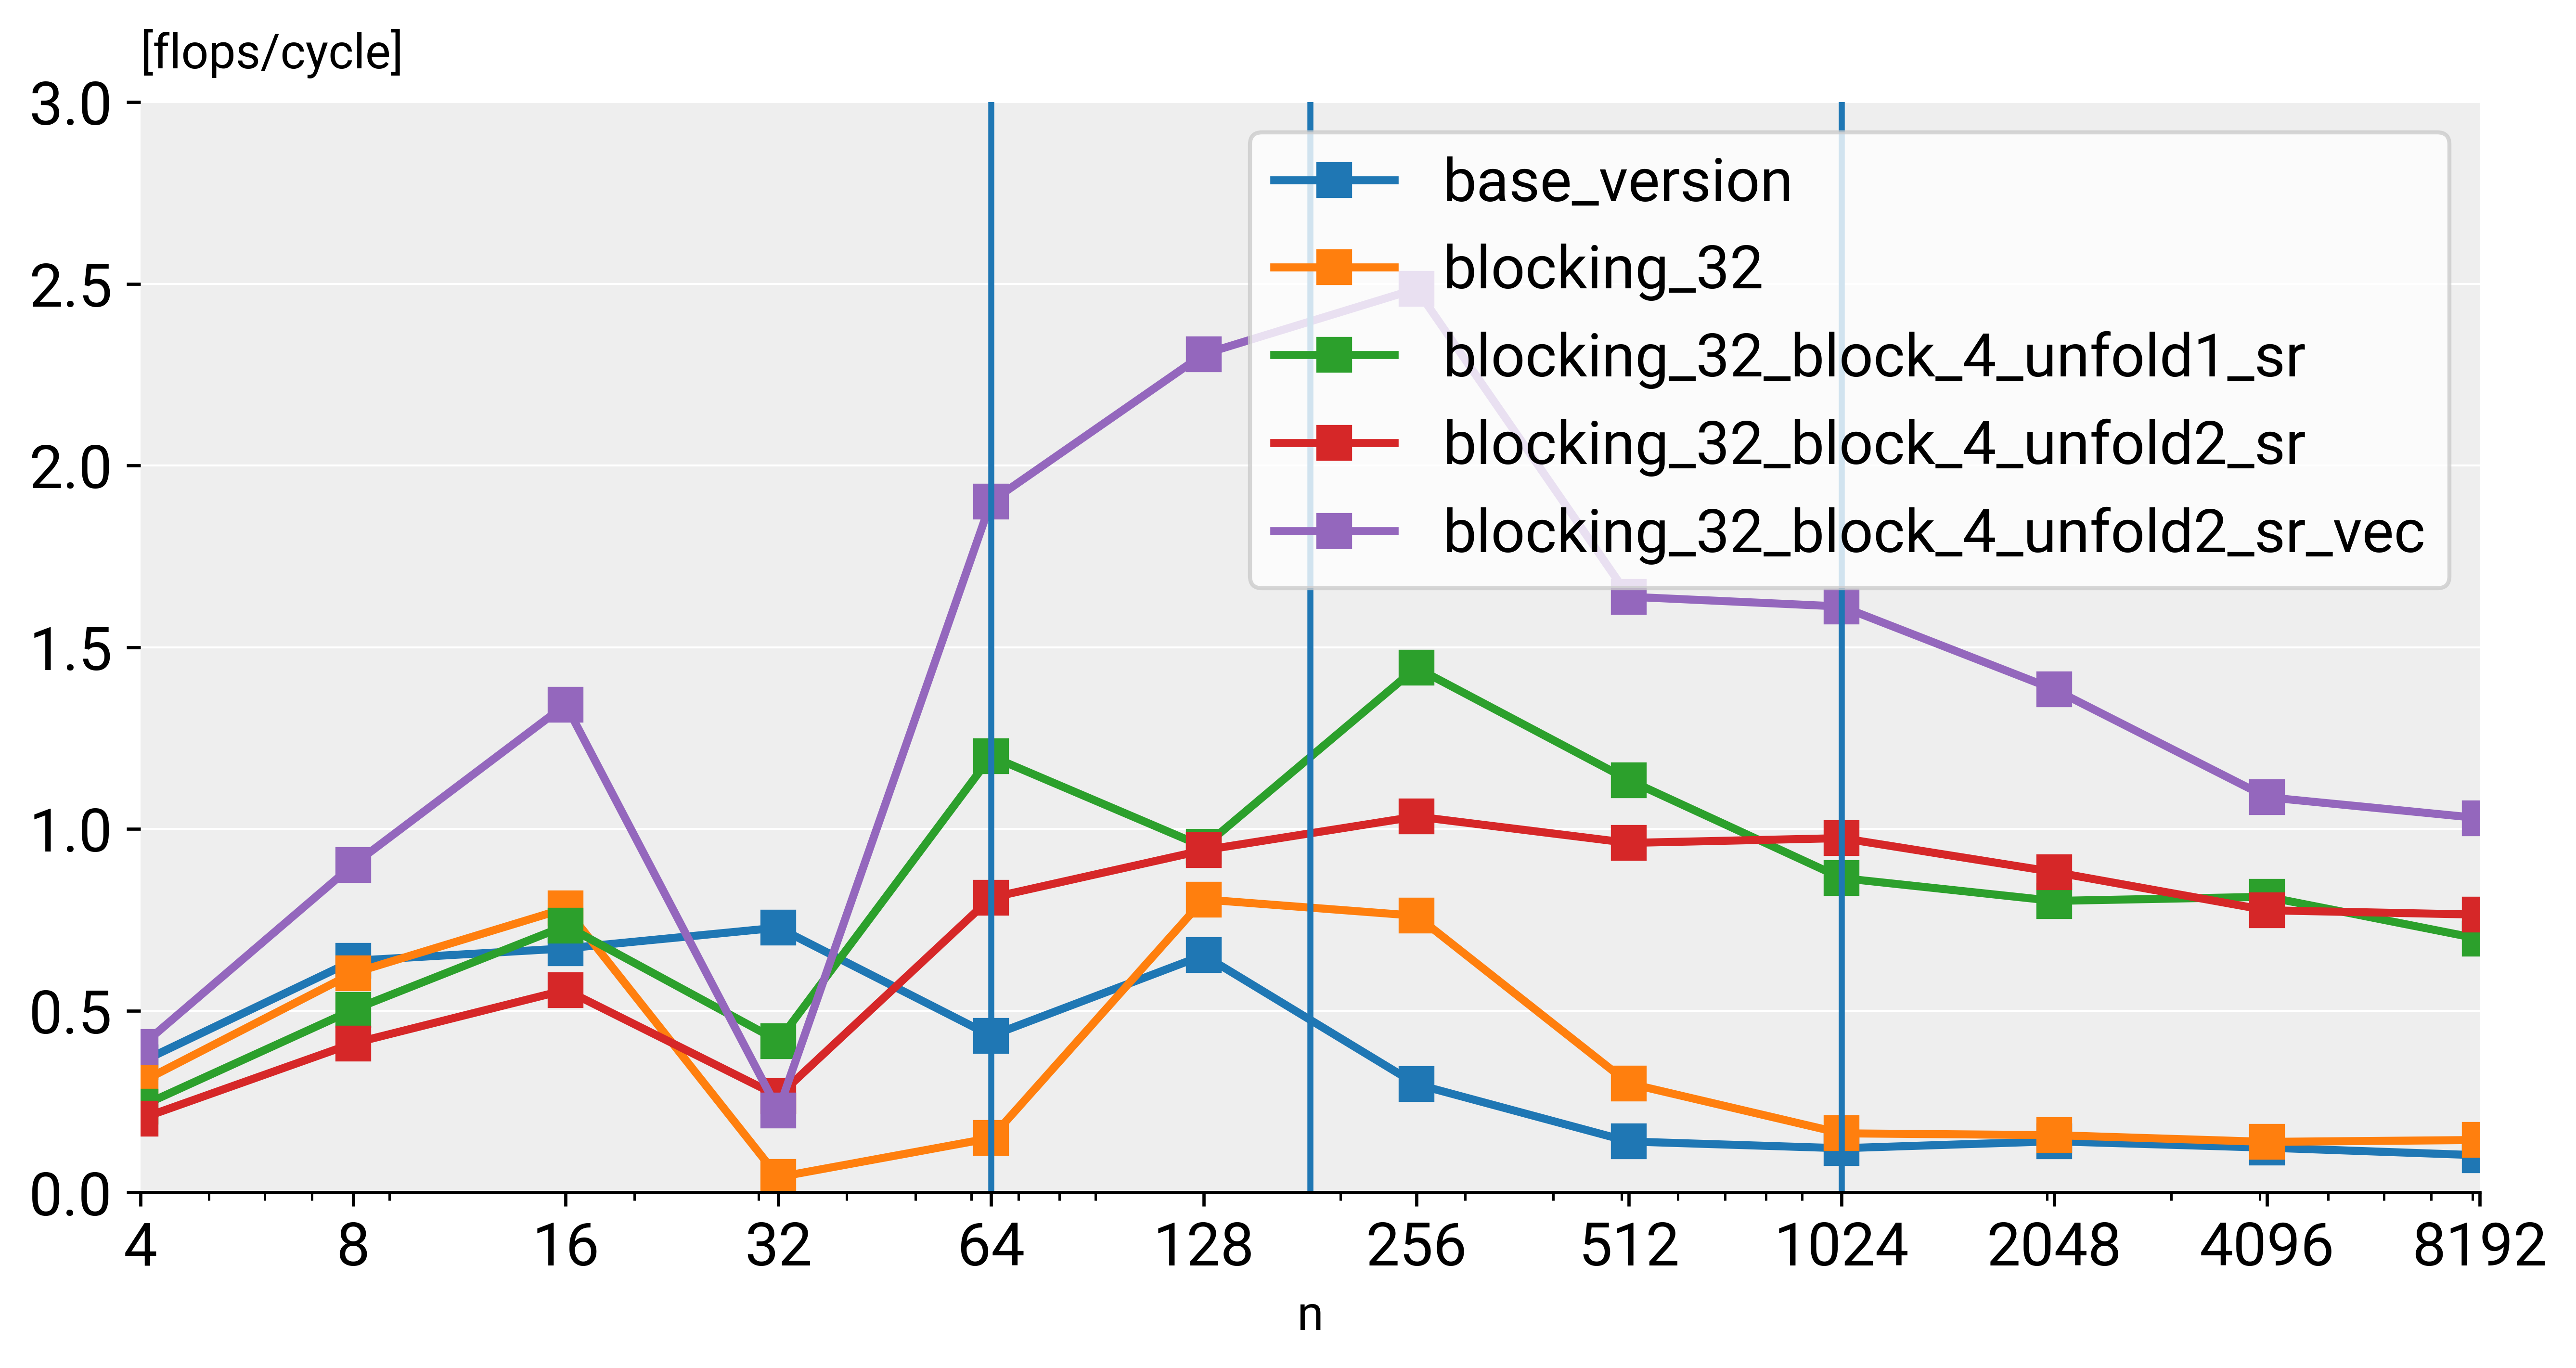

In [11]:
data = pd.read_csv("./bench5.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = get_flops(N)

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops / cycles
    perf.append(P)

ax = plot(N, perf, labels=func_names, ylim=3)
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()